In [1]:
import trainer, os
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'c:\\Users\\Hoon\\Nextcloud3\\Projects\\AudioTrain'

In [3]:
splited_dataset = trainer.prepare_data('project-1-at-2024-10-14-18-00-93e82746.json')     

In [4]:
mfcc_features = trainer.get_mfcc(splited_dataset)
mfcc_features = {label: features*2 for label, features in mfcc_features.items()}


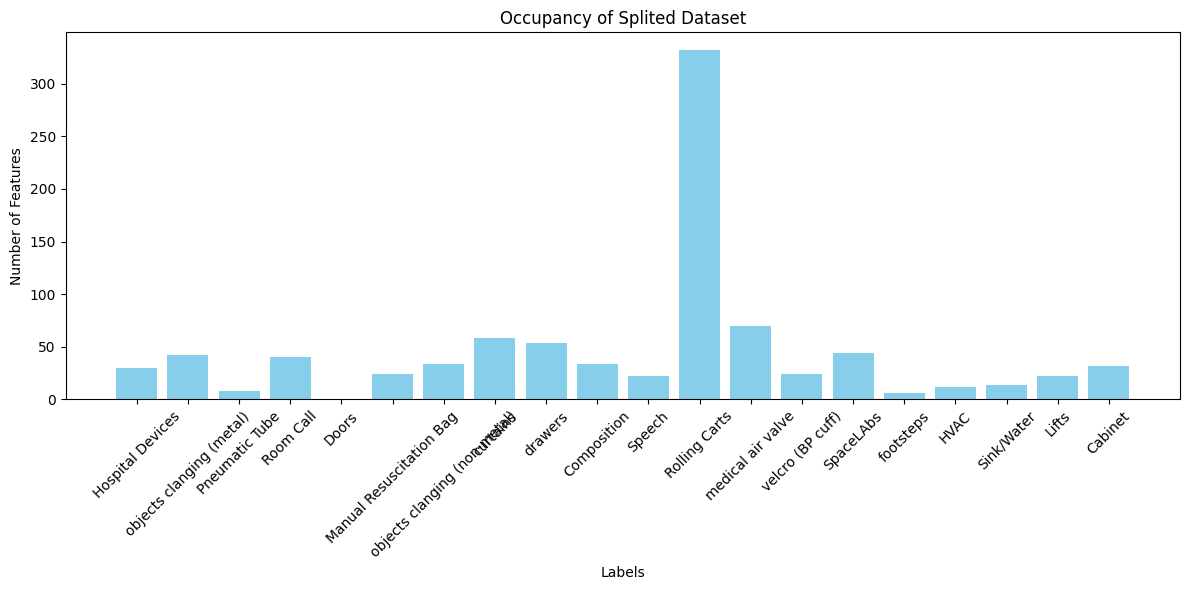

In [5]:
# Visualize the occupancy of the splited dataset
occupancy = {label: len(features) for label, features in mfcc_features.items()}
labels = list(occupancy.keys())
values = list(occupancy.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Number of Features')
plt.title('Occupancy of Splited Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:

x_train, x_test, y_train, y_test, label = trainer.split_data(mfcc_features)

Training set size: 631
Testing set size: 271


In [7]:
model = trainer.build_model(x_train, x_test, y_train, y_test)

c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 19)             │         9,747 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 383,571 (1.46 MB)

 Trainable params: 383,571 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2634 - loss: 8.3895 - val_accuracy: 0.6236 - val_loss: 1.6349
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4938 - loss: 1.8655 - val_accuracy: 0.6199 - val_loss: 1.3758
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6289 - loss: 1.2991 - val_accuracy: 0.7601 - val_loss: 0.7861
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7534 - loss: 0.8595 - val_accuracy: 0.7749 - val_loss: 0.7658
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7921 - loss: 0.6587 - val_accuracy: 0.8044 - val_loss: 0.6210
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8337 - loss: 0.5300 - val_accuracy: 0.8376 - val_loss: 0.4875
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8588 - loss: 0.4450 - val_accuracy: 0.8930 - val_loss: 0.3898
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8772 - loss: 0.3529 - val_accuracy: 0.8782 - v

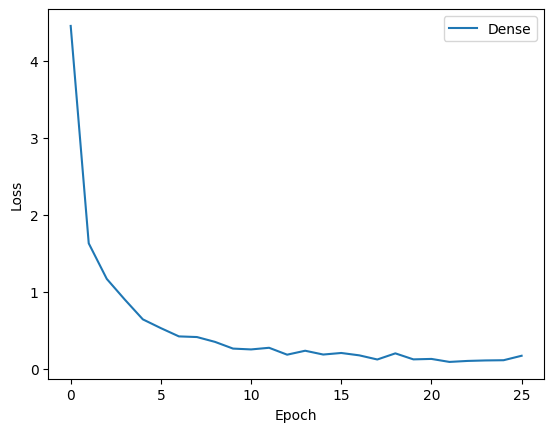

In [8]:

trainer.train(model, x_train, x_test, y_train, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9049 - loss: 0.2394 
Test Loss: 0.2260
Test Accuracy: 0.9041
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
                              precision    recall  f1-score   support

            Hospital Devices       0.78      1.00      0.88         7
    objects clanging (metal)       0.88      1.00      0.93        14
              Pneumatic Tube       1.00      0.60      0.75         5
                   Room Call       1.00      1.00      1.00        10
    Manual Resuscitation Bag       1.00      1.00      1.00         6
objects clanging (non-metal)       0.75      1.00      0.86         6
                    curtains       1.00      1.00      1.00        16
                     drawers       0.73      0.85      0.79        13
                 Composition       1.00      0.76      0.87        17
                      Speech       0.64      1.00      0.78         7
               Rolling Carts       0.98      0.90      0.94       104
         

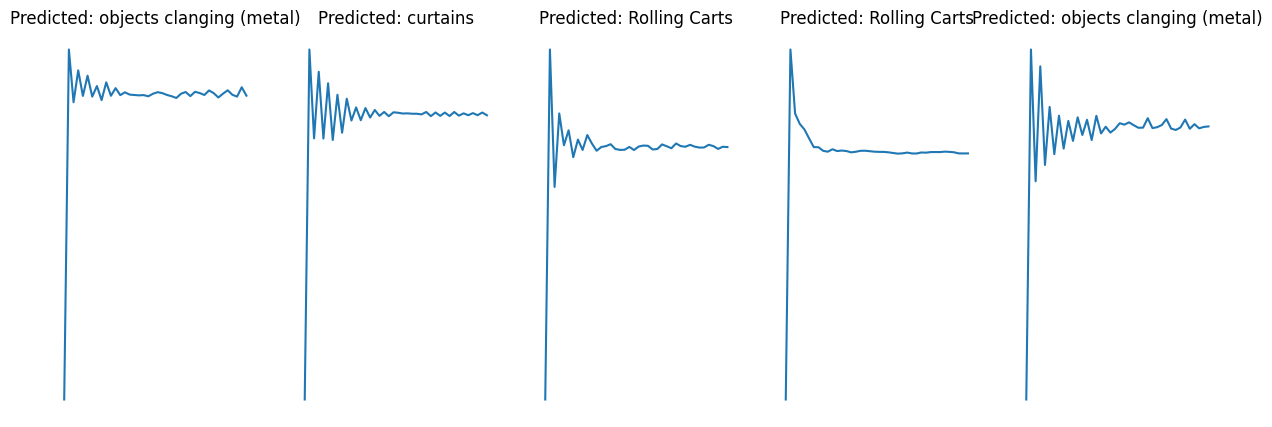

In [9]:
trainer.evaluate(model, x_test, y_test, label)

In [10]:
import tensorflow as tf
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to a .tflite file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Hoon\AppData\Local\Temp\tmpwp9agej6\assets


INFO:tensorflow:Assets written to: C:\Users\Hoon\AppData\Local\Temp\tmpwp9agej6\assets


Saved artifact at 'C:\Users\Hoon\AppData\Local\Temp\tmpwp9agej6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 19), dtype=tf.float32, name=None)
Captures:
  2573236999216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2573237004144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2573237378160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2573237374992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2573237385728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2573237386432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2573237506944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2573237507824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2573237517680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2573237668496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  25732376769

In [50]:
def predict_labels(x_test, model_path='model.tflite'):
    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Prepare the input data
    x_test_input = np.array([x_test.reshape(1, len(x_test), 1)], dtype=np.float32)
    
    # Set the tensor for the input
    interpreter.set_tensor(input_details[0]['index'], x_test_input[0])

    # Run the model
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Process the output data
    predicted_classes_tflite = np.argmax(output_data, axis=1)[0]
    # Get the labels from the dataset
    
    return predicted_classes_tflite

In [51]:
t = len(x_test)
for x, y in zip(x_test, y_test):
    resx = label[predict_labels(x)]
    resy = label[np.argmax(y)]
    if resx != resy:
        print(resx, ' != ' , resy)
        t -=1

print(t/len(x_test))
 

# 

Hospital Devices  !=  Pneumatic Tube
drawers  !=  Rolling Carts
objects clanging (non-metal)  !=  Rolling Carts
Sink/Water  !=  medical air valve
Cabinet  !=  Composition
medical air valve  !=  Sink/Water
drawers  !=  Rolling Carts
objects clanging (non-metal)  !=  Rolling Carts
objects clanging (metal)  !=  Rolling Carts
Hospital Devices  !=  Pneumatic Tube
objects clanging (metal)  !=  Rolling Carts
Speech  !=  Rolling Carts
Cabinet  !=  Composition
drawers  !=  Rolling Carts
Speech  !=  Composition
medical air valve  !=  Sink/Water
Sink/Water  !=  medical air valve
Speech  !=  Composition
medical air valve  !=  Sink/Water
drawers  !=  Rolling Carts
medical air valve  !=  Sink/Water
Rolling Carts  !=  drawers
medical air valve  !=  Sink/Water
Rolling Carts  !=  drawers
medical air valve  !=  Sink/Water
Speech  !=  Rolling Carts
0.9040590405904059


In [ ]:
model.save('model.h5')


: 

In [ ]:
from keras.models import load_model

# Load the model
model = load_model('model.h5')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Make predictions
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Generate a classification report
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=[label[i] for i in np.unique(true_classes)])
print(report)


: 

: 